## TASK 03:

Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic data.

Import libraries :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import graphviz
from sklearn import tree

Load dataset :

In [3]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

# Exploratory Data Analysis :

Visualize target variable distribution :

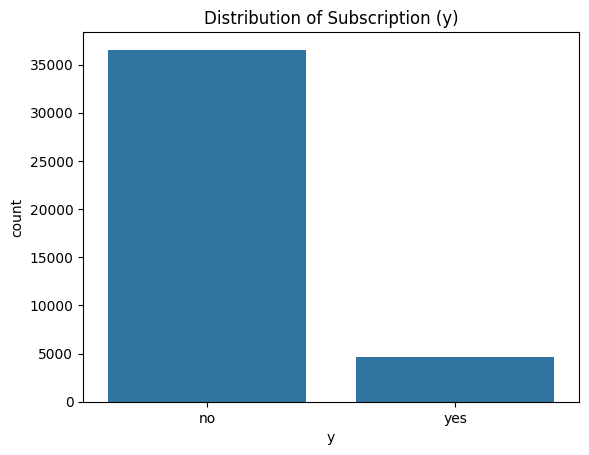

In [4]:
sns.countplot(data=df, x='y')
plt.title('Distribution of Subscription (y)')
plt.show()

Job vs Subscription Rate :

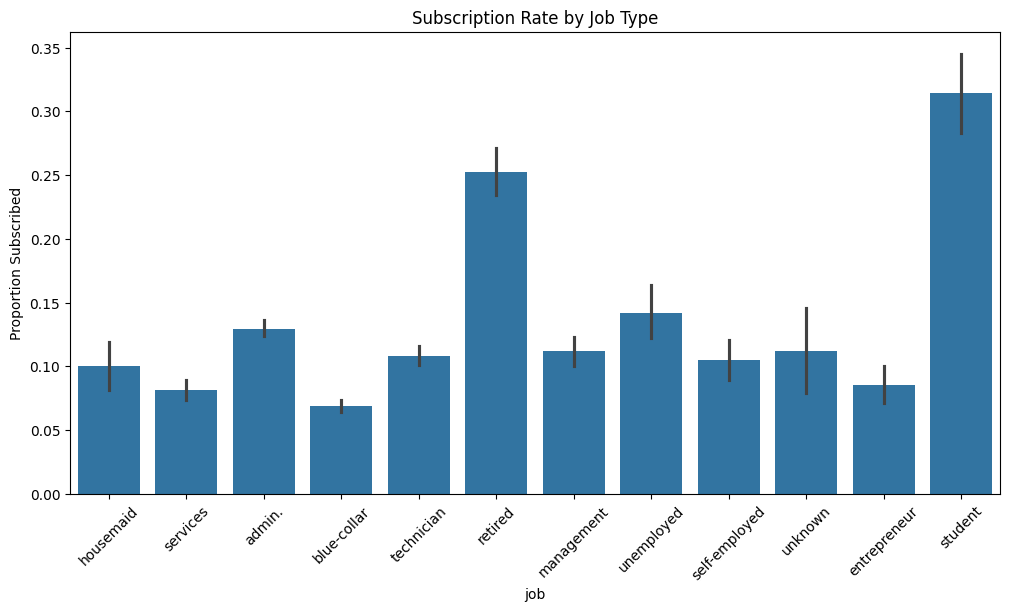

In [5]:
plt.figure(figsize=(12,6))
sns.barplot(x='job', y=(df['y'] == 'yes').astype(int), data=df, estimator='mean')
plt.xticks(rotation=45)
plt.title('Subscription Rate by Job Type')
plt.ylabel('Proportion Subscribed')
plt.show()

Marital Status vs Subscription :

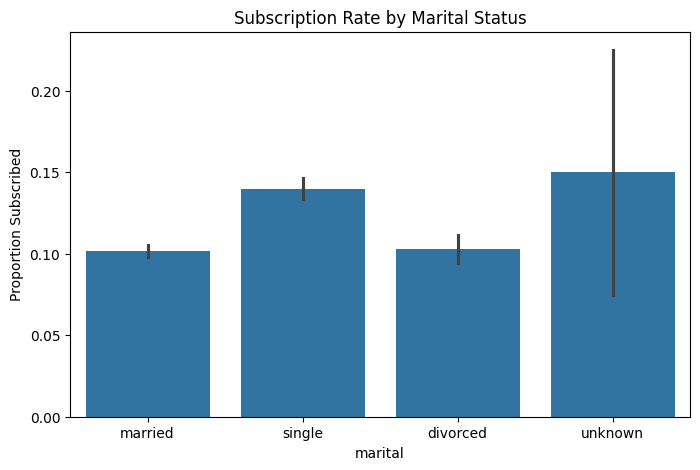

In [6]:
plt.figure(figsize=(8,5))
sns.barplot(x='marital', y=(df['y'] == 'yes').astype(int), data=df, estimator='mean')
plt.title('Subscription Rate by Marital Status')
plt.ylabel('Proportion Subscribed')
plt.show()

Education vs Subscription :

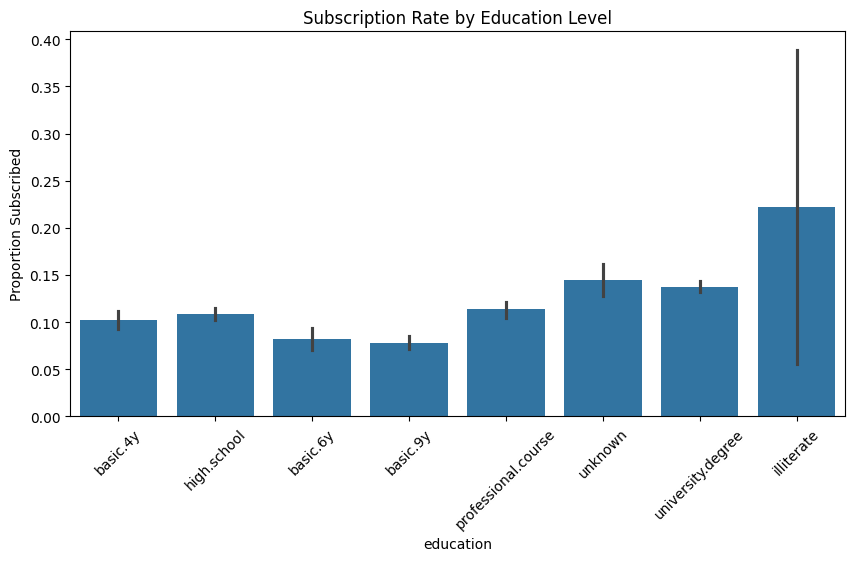

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(x='education', y=(df['y'] == 'yes').astype(int), data=df, estimator='mean')
plt.xticks(rotation=45)
plt.title('Subscription Rate by Education Level')
plt.ylabel('Proportion Subscribed')
plt.show()

Age distribution :

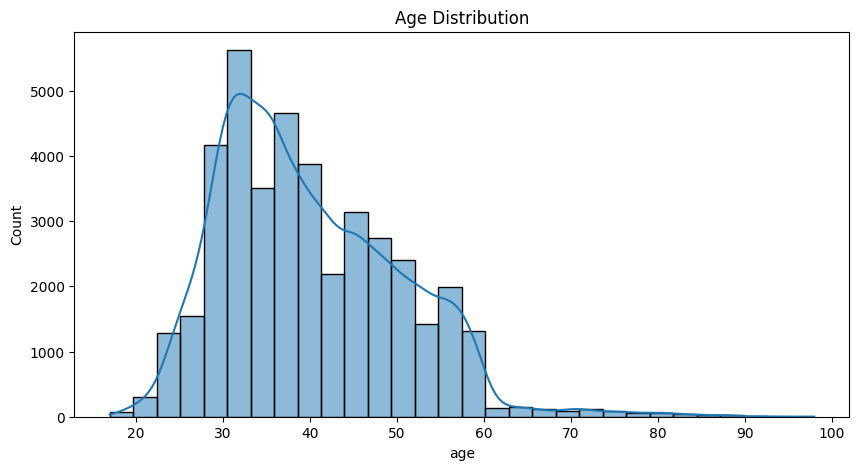

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

Correlation Heatmap (post encoding):

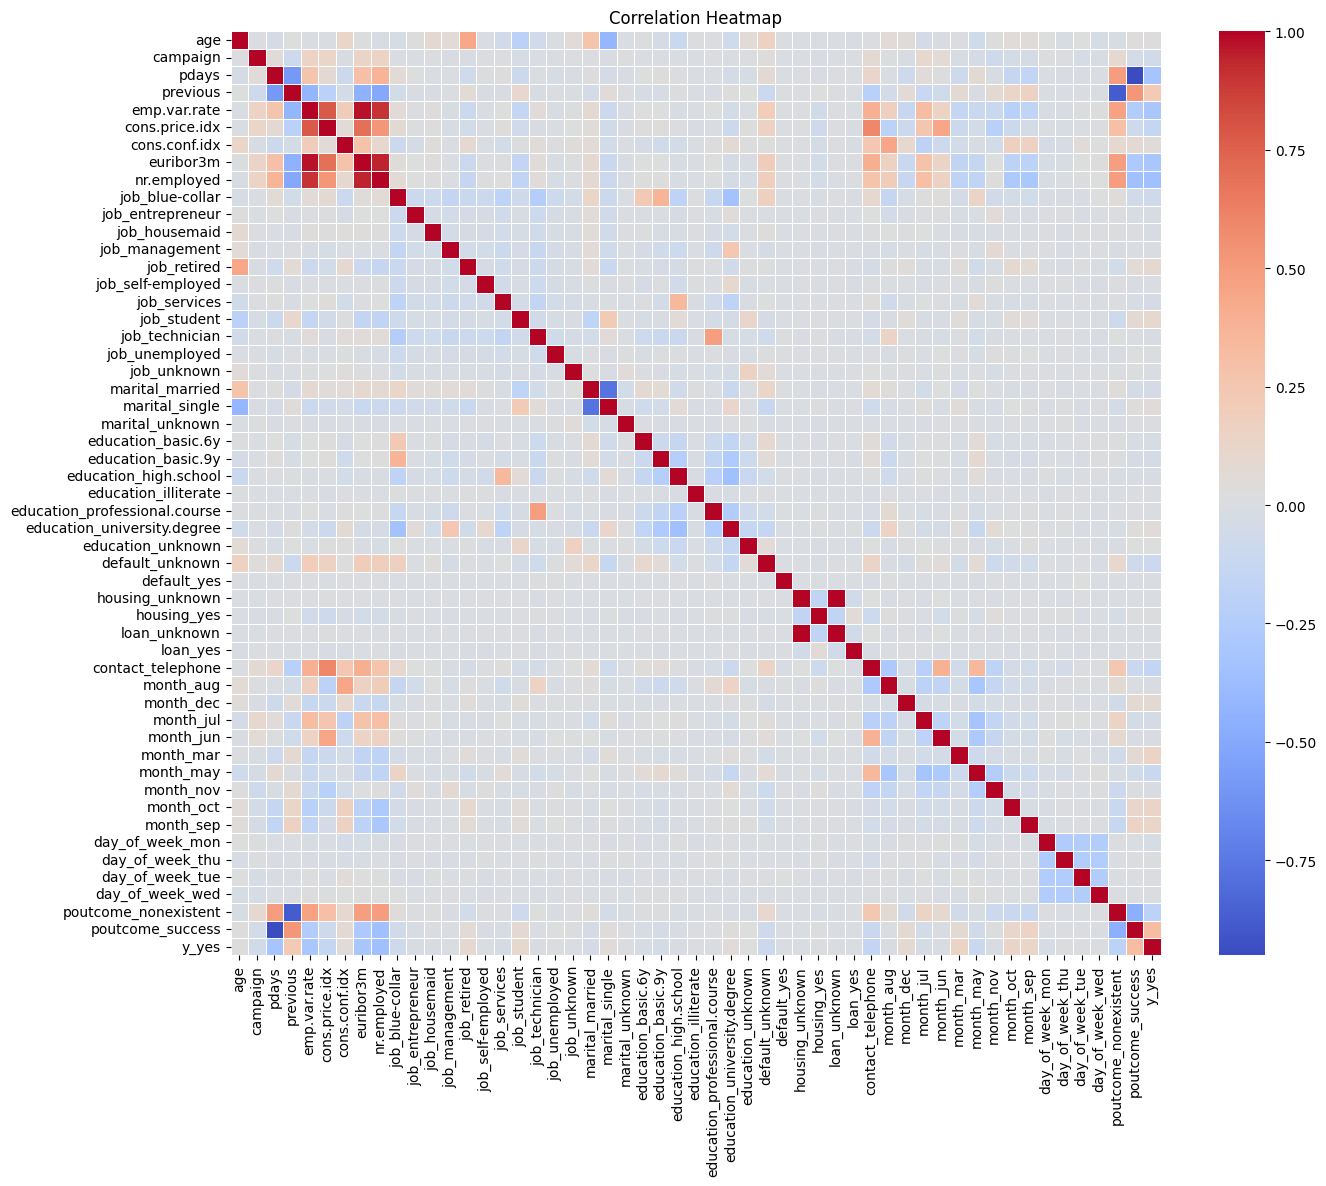

In [9]:
df_encoded = pd.get_dummies(df.drop(columns=['duration']), drop_first=True)
plt.figure(figsize=(15,12))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Data Preparation & SMOTE :

In [10]:
X = df_encoded.drop(columns=['y_yes'])
y = df_encoded['y_yes']

Apply SMOTE for balancing classes :

In [11]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Stratified train-test split :

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# ID3 (Entropy-based Tree) :

In [13]:
id3_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

Cross-validation ;

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
id3_scores = cross_val_score(id3_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print("ID3 - Cross-Validation Accuracy:", id3_scores.mean())

ID3 - Cross-Validation Accuracy: 0.7593028973313873


Fit the model :

In [15]:
id3_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

Model evaluation :

In [16]:
id3_pred = id3_model.predict(X_test)
print("ID3 - Classification Report:\n", classification_report(y_test, id3_pred))

ID3 - Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.92      0.80      7310
        True       0.88      0.61      0.72      7310

    accuracy                           0.77     14620
   macro avg       0.79      0.77      0.76     14620
weighted avg       0.79      0.77      0.76     14620



Confusion Matrix:

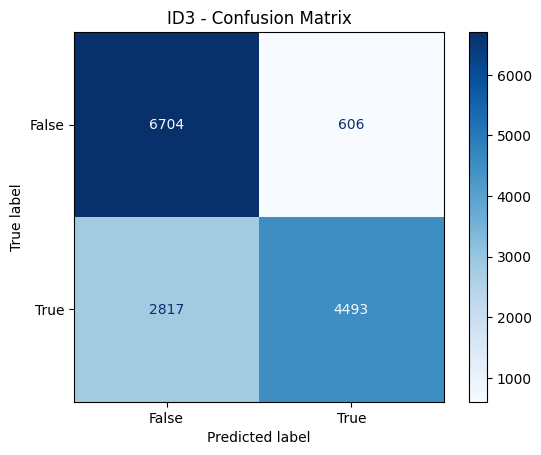

In [17]:
cm = confusion_matrix(y_test, id3_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id3_model.classes_)
fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax)
plt.title("ID3 - Confusion Matrix")
plt.grid(False)
plt.show()

ROC Curve & AUC:

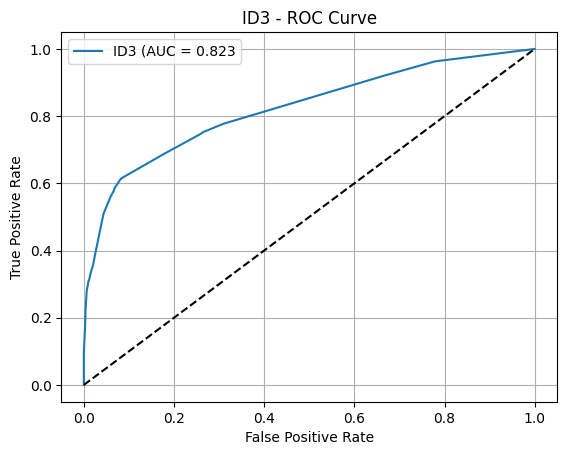

In [18]:
y_probs = id3_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_id3 = roc_auc_score(y_test, y_probs)
plt.plot(fpr, tpr, label=f'ID3 (AUC = {auc_id3:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ID3 - ROC Curve')
plt.legend()
plt.grid()
plt.show()

Feature importance:

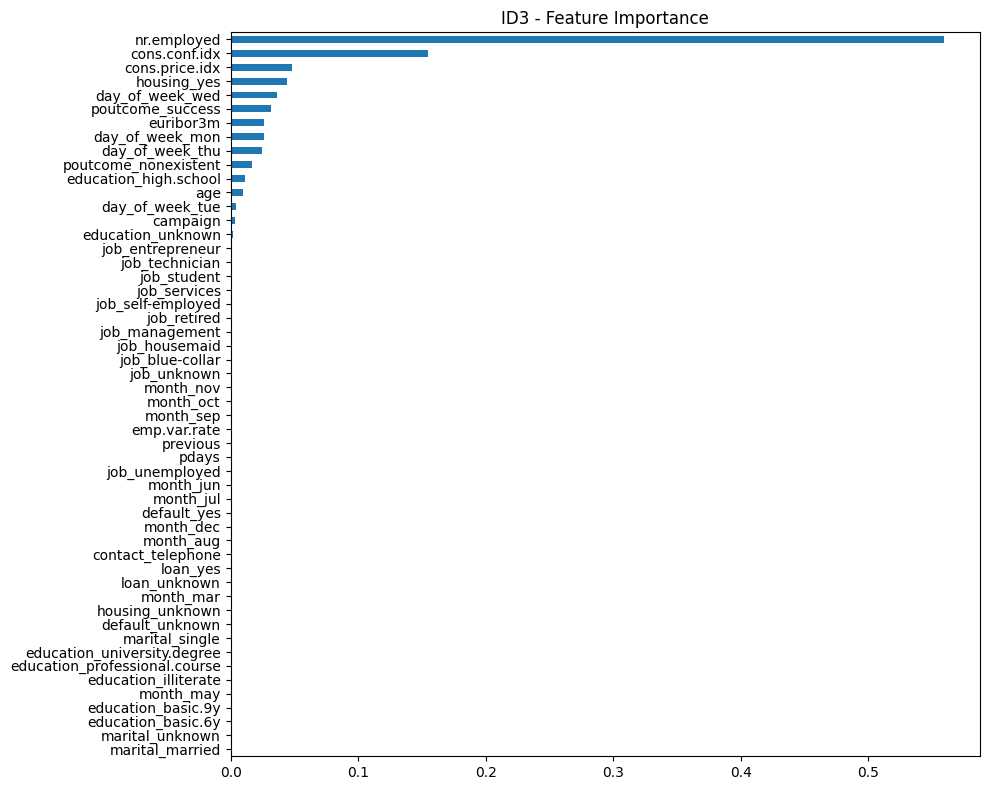

In [19]:
importances = pd.Series(id3_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8), title='ID3 - Feature Importance')
plt.tight_layout()
plt.show()

Tree complexity:

In [20]:
print("ID3 - Tree Depth:", id3_model.get_depth())
print("ID3 - Number of Leaves:", id3_model.get_n_leaves())

ID3 - Tree Depth: 5
ID3 - Number of Leaves: 30


Visualize the decision tree (ID3):

In [21]:
id3_dot = tree.export_graphviz(
    id3_model,
    out_file=None,
    feature_names=X.columns,
    class_names=['no', 'yes'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(id3_dot)
graph.render("id3_tree", format="png", cleanup=False)

'id3_tree.png'

# CART (Gini-based Tree):

In [22]:
gini_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

Cross-validation:

In [23]:
gini_scores = cross_val_score(gini_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
print("Gini - Cross-Validation Accuracy:", gini_scores.mean())

Gini - Cross-Validation Accuracy: 0.7584136436204632


Fit the model:

In [24]:

gini_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

Model evaluation:

In [25]:
gini_pred = gini_model.predict(X_test)
print("Gini - Classification Report:\n", classification_report(y_test, gini_pred))

Gini - Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.92      0.80      7310
        True       0.88      0.61      0.72      7310

    accuracy                           0.77     14620
   macro avg       0.79      0.77      0.76     14620
weighted avg       0.79      0.77      0.76     14620



Confusion Matrix:

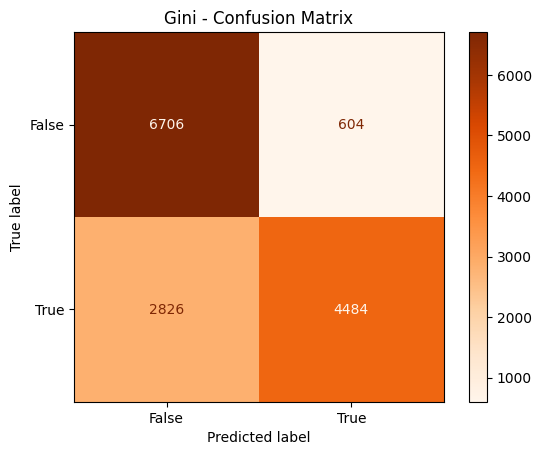

In [26]:
cm = confusion_matrix(y_test, gini_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gini_model.classes_)
fig, ax = plt.subplots()
disp.plot(cmap='Oranges', ax=ax)
plt.title("Gini - Confusion Matrix")
plt.grid(False)
plt.show()

ROC Curve & AUC:

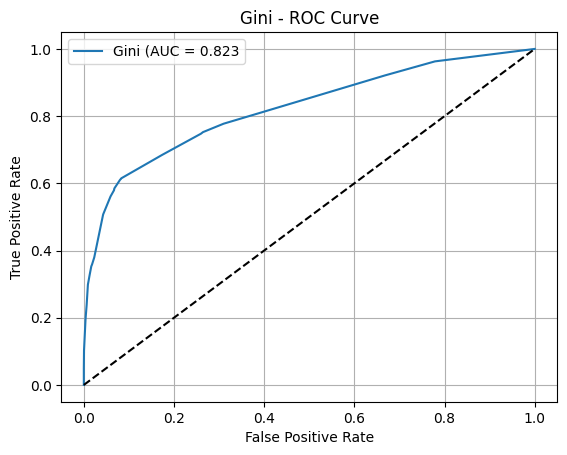

In [27]:
y_probs_gini = gini_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_gini)
auc_gini = roc_auc_score(y_test, y_probs_gini)
plt.plot(fpr, tpr, label=f'Gini (AUC = {auc_gini:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gini - ROC Curve')
plt.legend()
plt.grid()
plt.show()

Feature importance:

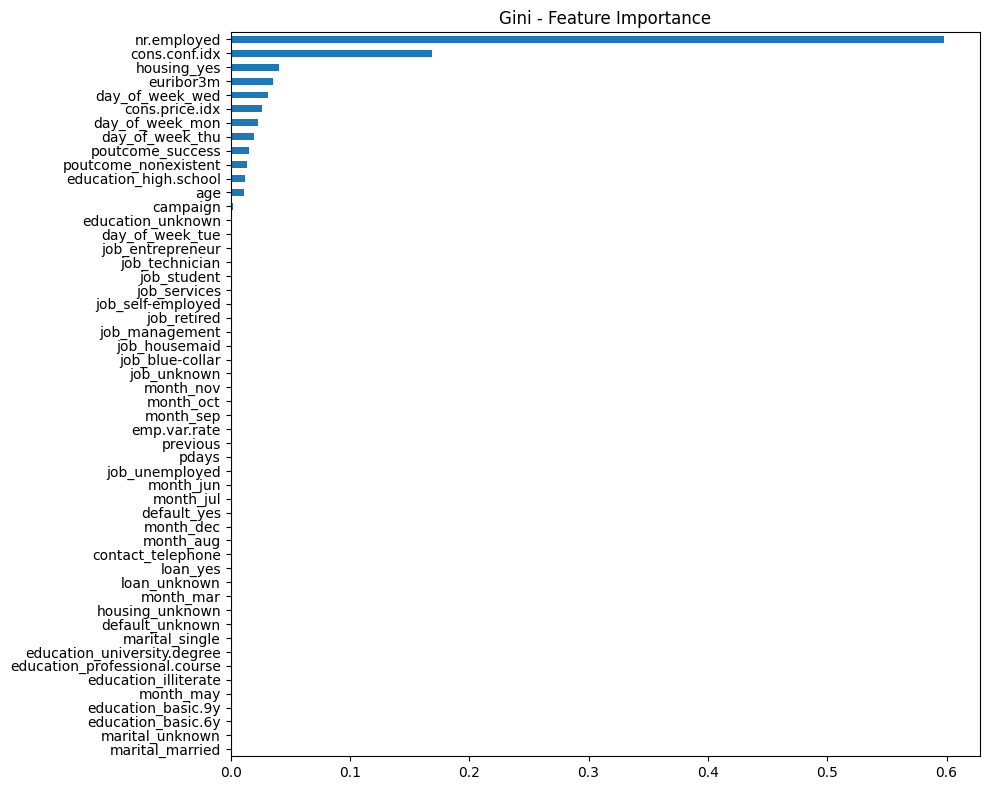

In [28]:
importances = pd.Series(gini_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8), title='Gini - Feature Importance')
plt.tight_layout()
plt.show()

Tree complexity:

In [29]:
print("Gini - Tree Depth:", gini_model.get_depth())
print("Gini - Number of Leaves:", gini_model.get_n_leaves())

Gini - Tree Depth: 5
Gini - Number of Leaves: 29


Visualize the decision tree (Gini):

In [30]:
gini_dot = tree.export_graphviz(
    gini_model,
    out_file=None,
    feature_names=X.columns,
    class_names=['no', 'yes'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph_gini = graphviz.Source(gini_dot)
graph_gini.render("gini_tree", format="png", cleanup=False)

'gini_tree.png'